In [1]:
import pandas as pd
import numpy as np
import os

In [5]:
def mapping(x):
    if x in [1.0]:
        return 'Current'
    elif x in [2.0]:
        return 'Former'
    elif x in [3.0]:
        return 'Never'
    else:
        return 'Unknown'
def get_value(hsr, col, index,title):
    temp = pd.DataFrame(hsr[col].value_counts().reindex(index, fill_value=0))
    temp1 = pd.DataFrame(round((hsr[col].value_counts().reindex(index, fill_value=0) / len(hsr)) * 100, 1))

    final = pd.concat([temp, temp1], axis=1)
    final.columns = ['count', 'percentage']

    final['count'] = final['count'].astype(int)
    final['final'] = final.apply(lambda row: f"{int(row['count']):,} ({row['percentage']}%)", axis=1)
    
    final = final.drop(columns=['count', 'percentage']).reset_index()
    temp = pd.DataFrame([[title, np.nan]])
    temp.columns=final.columns

    return pd.concat([temp, final])
def get_mean(df, col, title):
    nan = df[col].isna().sum()
    mean = round(df[col].mean(),1)
    std = round(df[col].std(),1)
    p = round((nan/len(df))*100,1)
    age = pd.DataFrame([[title, np.nan],['Mean (SD)', f'{mean} ({std})'], ['Missing', f'{nan:,} ({p}%)']])
    age.columns = ['index', 'final']
    return age
    
def get_stat(df, name):
    age = get_mean(df, 'age', 'Age')
    sex = get_value(df,'sex', ['Female', 'Male'], 'Sex')
    age.columns = sex.columns
    race = get_value(df,'race_ethnicity', ['Hispanic', 'NHB', 'NHW', 'Other', 'Unknown'], 'Race/ethnicity')
    df['continuity'] = df.mpec.apply(lambda x: 'High' if x>0.3 else 'Low')
    continuity = get_value(df,'continuity', ['Low', 'High'], 'EHR data-continuity')
    df['smoking'] = df.smoking.apply(mapping)
    smoking = get_value(df,'smoking', ['Current', 'Former', 'Never','Unknown', ], 'Somking')
    cci = get_mean(df, 'CCI_flags', 'Charlson comorbidity Index')
    Hypertension = get_value(df,'Hypertension', [1,0 ], 'Hypertension')
    dbp = get_mean(df, 'DIASTOLIC', 'Diastolic blood pressure')
    sbp = get_mean(df, 'SYSTOLIC', 'Systolic blood pressure')
    df.loc[df['ORIGINAL_BMI'] > 100, 'ORIGINAL_BMI'] = np.nan
    bmi = get_mean(df, 'ORIGINAL_BMI', 'Body mass index')
    head = pd.DataFrame([[np.nan,name], [np.nan, f'(N={len(df):,})']])
    head.columns = bmi.columns
    final = pd.concat([head, age,sex,race,smoking,continuity,cci, Hypertension, dbp, sbp, bmi])
    return final

In [17]:
years = [1,3,5]
root = '/Users/yu.hu/Desktop/hpg_code/Continuity/orange_Continiuity_final_cohort_12_10_knn_target_seperate_absolute_match'
for year in years:
    outcome = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_outcome.csv')
    hsr = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_case_HSR_flag.csv')
    cp1 = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_case_CP1_flag.csv')
    cp2 = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_case_CP2_flag.csv')
    three = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_cp1+cp2+hsr.csv')
    hsr = get_stat(hsr[hsr.case_HSR_flag == 1], 'HSR')
    cp1 = get_stat(cp1[cp1.case_CP1_flag == 1], 'CP1').drop(columns=['index'])
    cp2 = get_stat(cp2[cp2.case_CP2_flag ==1 ], 'CP2').drop(columns=['index'])
    three = get_stat(three[three['cp1+cp2+hsr'] == 1], 'CP1 & CP2 & HSR').drop(columns=['index'])
    all_df = pd.concat([hsr, cp1, cp2, three], axis = 1)
    # all_df.to_csv(f'{year}_table1.csv', index=False)
    

/var/folders/qd/p70m9c454hb0dg39fvsykmjrxprw2j/T/ipykernel_79261/2116927763.py:4: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  outcome = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_outcome.csv')
/var/folders/qd/p70m9c454hb0dg39fvsykmjrxprw2j/T/ipykernel_79261/2116927763.py:5: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  hsr = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_case_HSR_flag.csv')
/var/folders/qd/p70m9c454hb0dg39fvsykmjrxprw2j/T/ipykernel_79261/2116927763.py:8: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  three = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_cp1+cp2+hsr.csv')
/var/folders/qd/p70m9c454hb0dg39fvsykmjrxprw2j/T/ipykernel_79261/2685452691.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

# huang yu check

1year: 0.125
low continuity median 0.0833333333333333
low continuity count(percentage) 13468 77.45%
high continuity median 0.5
high continuity count(percentage) 3921 22.55%


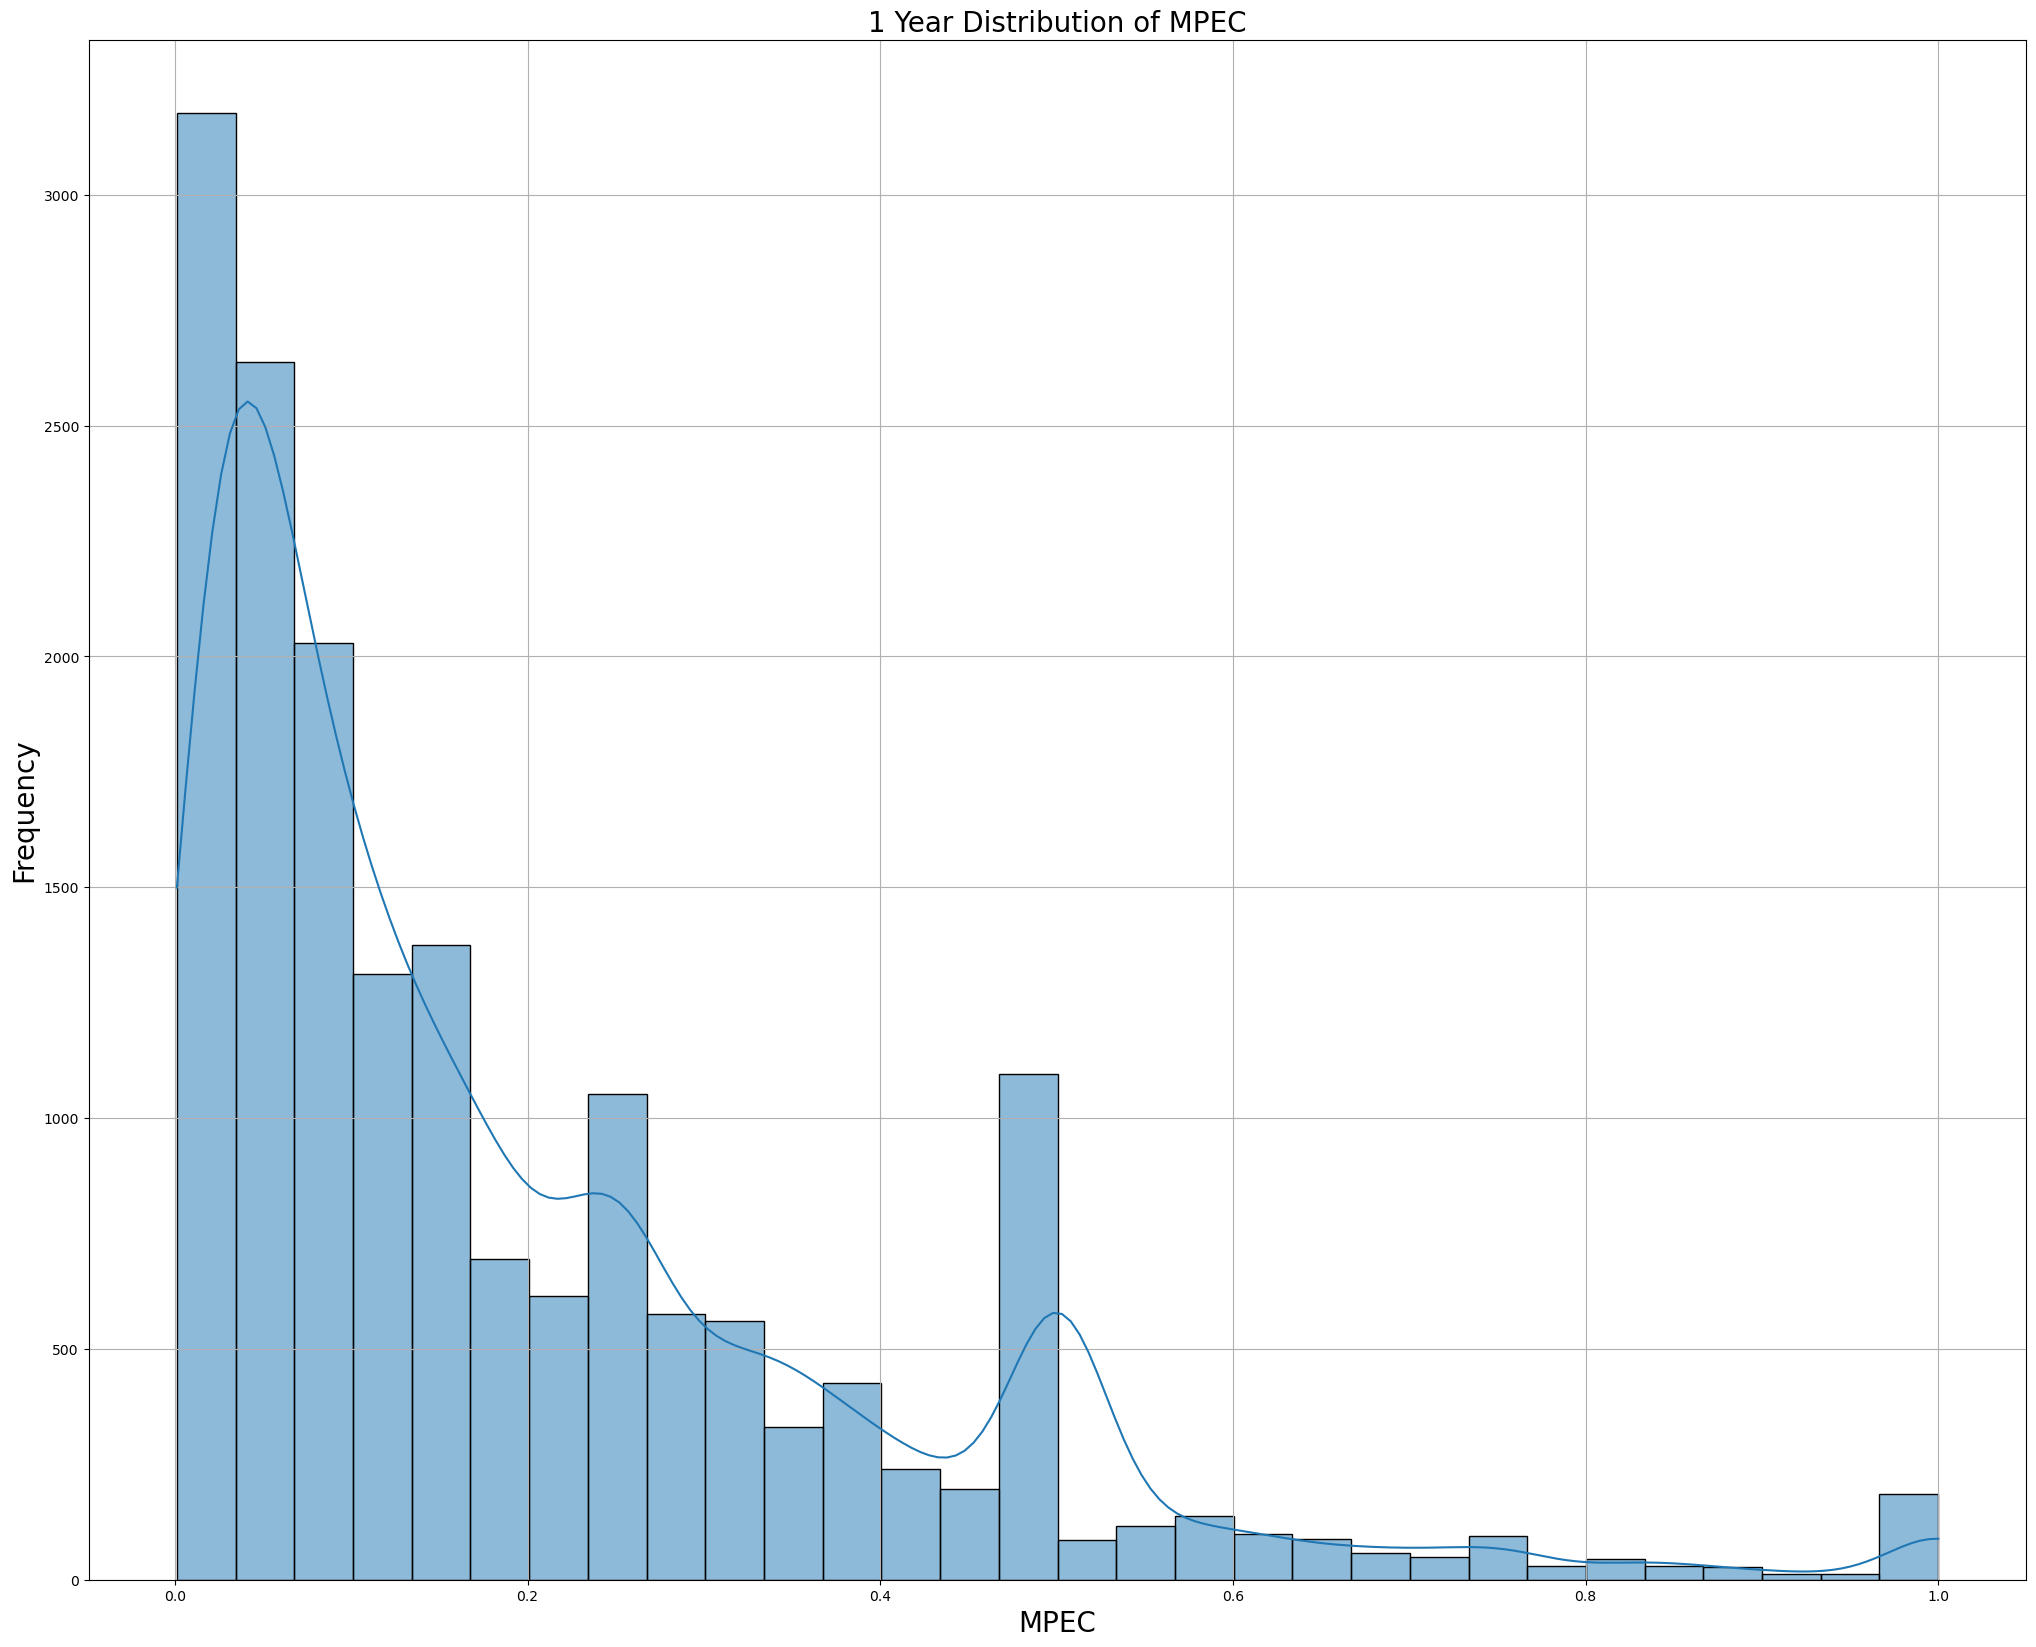

3year: 0.0909090909090909
low continuity median 0.0625
low continuity count(percentage) 20475 81.38%
high continuity median 0.5
high continuity count(percentage) 4686 18.62%


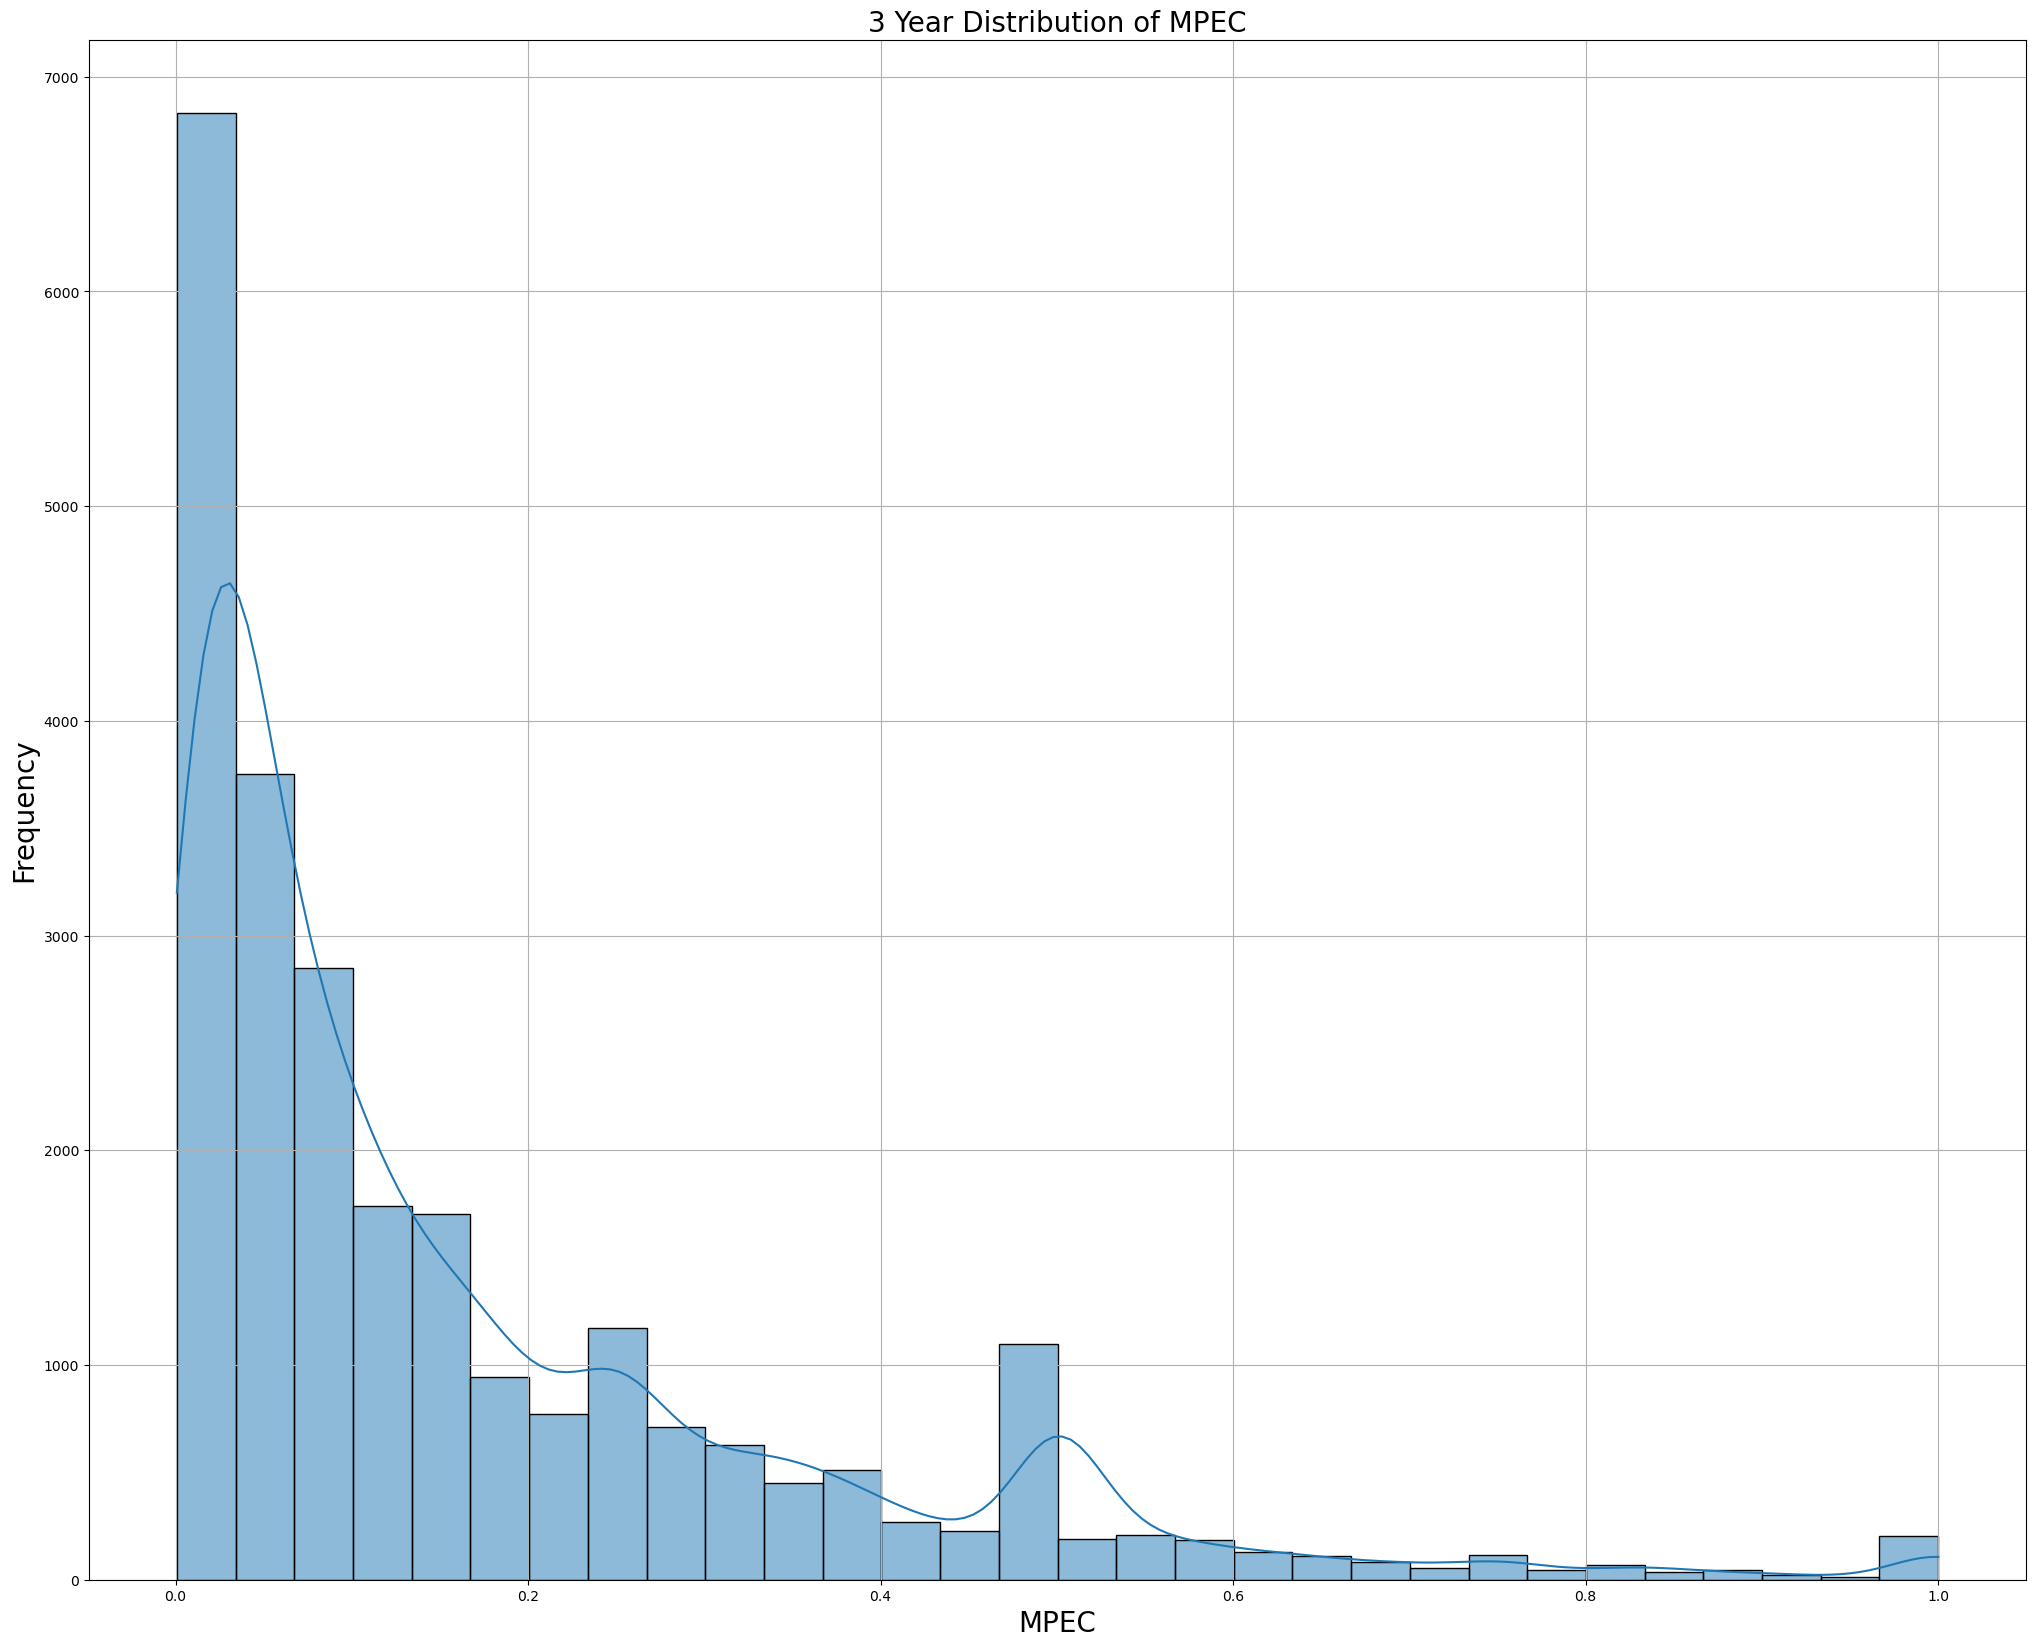

5year: 0.0833333333333333
low continuity median 0.0555555555555555
low continuity count(percentage) 24070 82.48%
high continuity median 0.5
high continuity count(percentage) 5113 17.52%


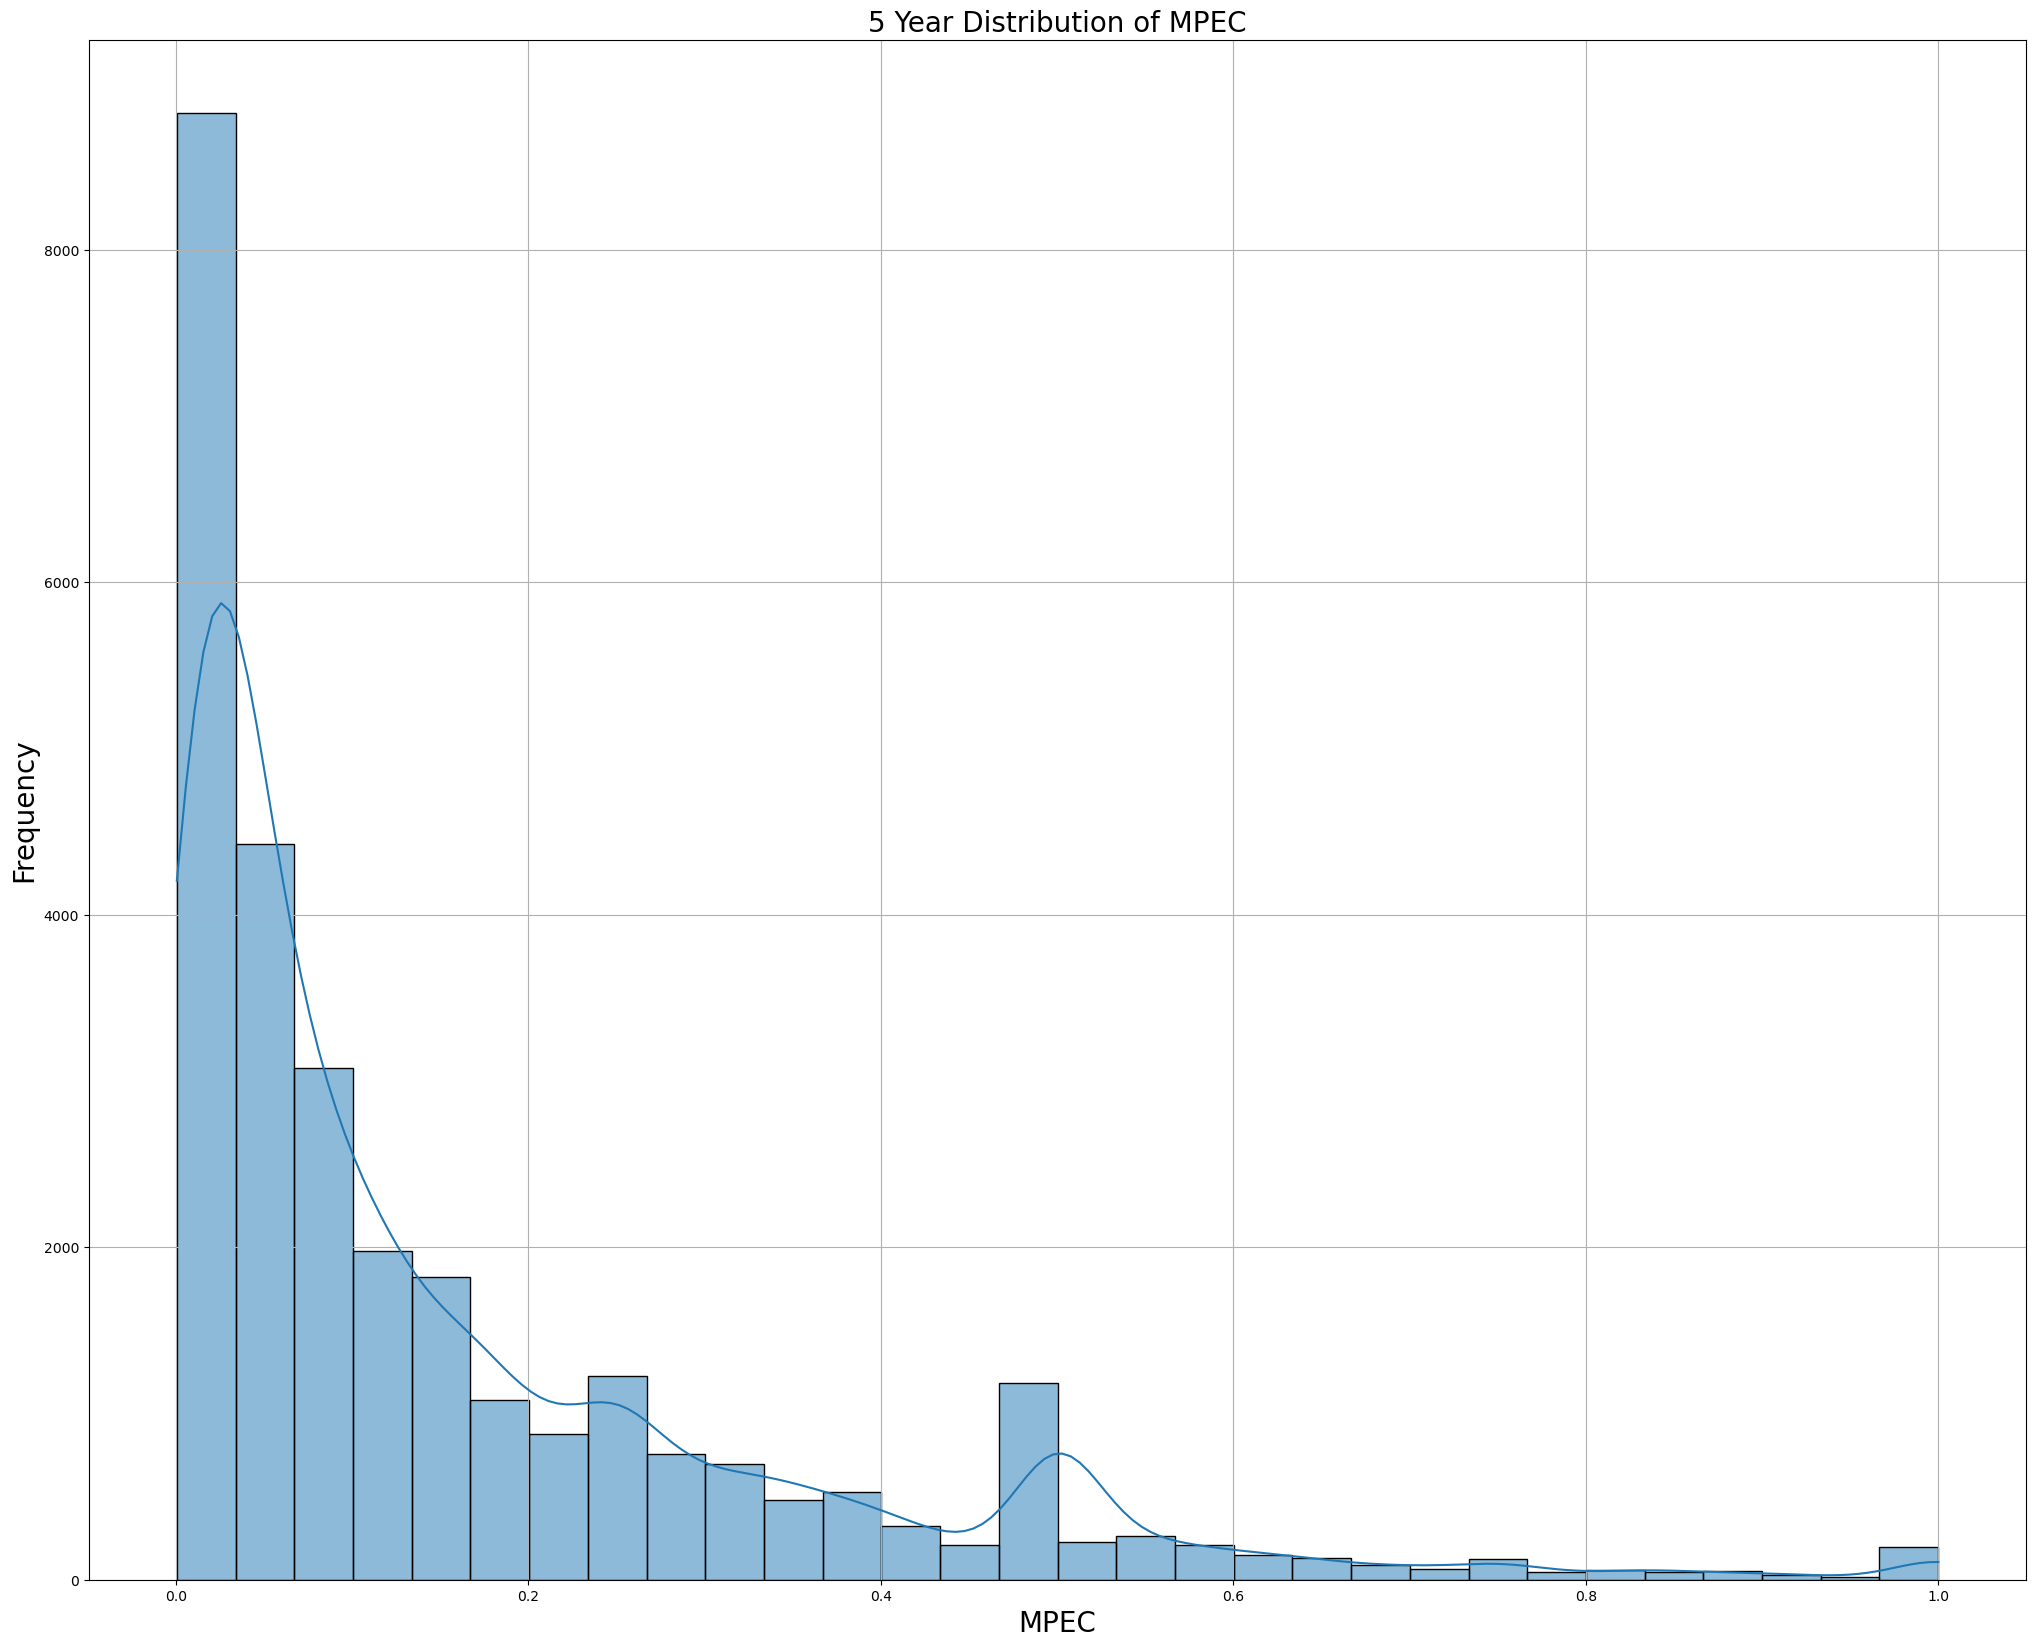

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
years = [1,3,5]
root = '/orange/chenaokun1990/huyu/continunity/final_cohort_12_10_knn_target_seperate_absolute_match'
for year in years:
    temp = pd.read_csv(f'{root}/unmatch_cohort_baseline_{year}year.csv')
    temp = temp[temp.outcome == 1]
    low = temp[temp.mpec <= 0.3].mpec.median()
    high = temp[temp.mpec > 0.3].mpec.median()
    print(f'{year}year:', temp[temp.outcome == 1].mpec.median())
   
    print('low continuity median', low)
    print('low continuity count(percentage)', len(temp[temp.mpec <= 0.3]),f'{round((len(temp[temp.mpec <= 0.3])/len(temp))*100,2)}%')
    print('high continuity median', high)
    print('high continuity count(percentage)', len(temp[temp.mpec > 0.3]),f'{round((len(temp[temp.mpec > 0.3])/len(temp))*100,2)}%')
    plt.figure(figsize=(25, 20))
    sns.histplot(temp['mpec'], bins=30, kde=True)
    plt.xlabel('MPEC',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)
    title = f'{year} Year Distribution of MPEC'
    plt.title(f'{year} Year Distribution of MPEC',fontsize=20)
    plt.grid(True)
    plt.savefig(f'{title}.png')
    plt.show()
    # all_df.to_csv(f'{year}_table1.csv', index=False)
    

In [53]:
t = pd.read_csv(f'{root}/unmatch_cohort_baseline_1year.csv')
t = t[t.outcome == 1]

In [54]:
t1 = pd.read_csv(f'{root}/unmatch_cohort_baseline_3year.csv')
t1 = t1[t1.outcome == 1]

In [60]:
pd.merge(t[['ID', 'mpec']],t1[['ID', 'mpec']],on='ID',how='inner')

,ID,mpec_x,mpec_y
0,31Dec2023t2d_continuity00000029,0.022619,0.022619
1,31Dec2023t2d_continuity00000046,0.266667,0.215385
2,31Dec2023t2d_continuity00000107,0.250000,0.250000
3,31Dec2023t2d_continuity00000125,0.602941,0.620690
4,31Dec2023t2d_continuity00000146,0.113636,0.113636
...,...,...,...
17335,31Dec2023t2d_continuity00766396,0.011194,0.018897
17336,31Dec2023t2d_continuity00766417,0.100000,0.100000
17337,31Dec2023t2d_continuity00766433,0.227273,0.096154
17338,31Dec2023t2d_continuity00766444,0.317647,0.259259


In [58]:
t

,ID,age,race_ethnicity,sex,index_date,smoking,ORIGINAL_BMI,SYSTOLIC,DIASTOLIC,hba1c,...,op_enc_count_claim_all,ip_enc_count_claim_all,mpec_i,mpec_o,mpec,outcome,case_HSR_flag,case_CP1_flag,case_CP2_flag,cp1+cp2+hsr
0,31Dec2023t2d_continuity00000029,42.0,NHW,Male,2016-03-26 00:00:00,4.0,31.36,96.0,68.0,5.8,...,60,35,0.028571,0.016667,0.022619,1,0,0,0,0
1,31Dec2023t2d_continuity00000046,18.0,Hispanic,Male,2019-01-03 00:00:00,4.0,20.08,114.0,77.0,NaN,...,66,8,0.200000,0.333333,0.266667,1,0,0,0,0
2,31Dec2023t2d_continuity00000107,44.0,NHB,Female,2021-11-07 00:00:00,4.0,28.12,102.0,66.0,NaN,...,54,5,0.500000,0.000000,0.250000,1,1,0,0,1
3,31Dec2023t2d_continuity00000125,28.0,NHB,Female,2016-02-07 00:00:00,4.0,27.29,126.0,84.0,NaN,...,58,1,1.000000,0.205882,0.602941,1,0,0,0,0
4,31Dec2023t2d_continuity00000146,30.0,NHB,Female,2013-10-30 00:00:00,4.0,24.25,115.0,56.0,5.6,...,44,-1,-0.000000,0.227273,0.113636,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17384,31Dec2023t2d_continuity00766396,53.0,NHW,Male,2022-01-22 00:00:00,2.0,32.90,157.0,98.0,6.3,...,64,142,0.022388,0.000000,0.011194,1,1,0,0,1
17385,31Dec2023t2d_continuity00766417,53.0,Hispanic,Male,2013-10-28 00:00:00,4.0,28.30,140.0,81.0,NaN,...,10,-1,-0.000000,0.200000,0.100000,1,0,0,0,0
17386,31Dec2023t2d_continuity00766433,46.0,NHB,Male,2015-12-07 00:00:00,4.0,26.31,111.0,72.0,NaN,...,26,9,-0.000000,0.454545,0.227273,1,1,0,0,1
17387,31Dec2023t2d_continuity00766444,37.0,NHB,Male,2019-05-03 00:00:00,4.0,28.13,144.0,99.0,NaN,...,441,21,-0.000000,0.635294,0.317647,1,0,0,0,0


In [59]:
t1[t1.ID=='31Dec2023t2d_continuity00000029']

,ID,age,race_ethnicity,sex,index_date,smoking,ORIGINAL_BMI,SYSTOLIC,DIASTOLIC,hba1c,...,op_enc_count_claim_all,ip_enc_count_claim_all,mpec_i,mpec_o,mpec,outcome,case_HSR_flag,case_CP1_flag,case_CP2_flag,cp1+cp2+hsr
0,31Dec2023t2d_continuity00000029,42.0,NHW,Male,2016-03-26 00:00:00,4.0,31.36,96.0,68.0,5.8,...,60,35,0.028571,0.016667,0.022619,1,0,0,0,0


In [28]:
years = [1,3,5]
root = '/orange/chenaokun1990/huyu/continunity/final_cohort_12_10_knn_target_seperate_absolute_match'
for year in years:
    temp = pd.read_csv(f'{root}/unmatch_cohort_baseline_{year}year.csv')
    temp1 = get_stat(temp[temp.outcome == 1], 'temp')
    print(temp[temp.outcome == 1].shape)
    # all_df.to_csv(f'{year}_table1.csv', index=False)
    

/scratch/local/58553057/ipykernel_497315/2685452691.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['continuity'] = df.mpec.apply(lambda x: 'High' if x>0.3 else 'Low')
/scratch/local/58553057/ipykernel_497315/2685452691.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoking'] = df.smoking.apply(mapping)


(17389, 68)


/scratch/local/58553057/ipykernel_497315/2685452691.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['continuity'] = df.mpec.apply(lambda x: 'High' if x>0.3 else 'Low')
/scratch/local/58553057/ipykernel_497315/2685452691.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoking'] = df.smoking.apply(mapping)


(25161, 68)
(29183, 68)


/scratch/local/58553057/ipykernel_497315/2685452691.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['continuity'] = df.mpec.apply(lambda x: 'High' if x>0.3 else 'Low')
/scratch/local/58553057/ipykernel_497315/2685452691.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoking'] = df.smoking.apply(mapping)


In [37]:
baseline_year= 5
t = pd.read_csv(f'/orange/chenaokun1990/huyu/continunity/FLM_ELIGIBLE_COHORT(0,1]_Baseline_{baseline_year}YR.csv', index_col = 0)

In [39]:
t

,ID,OC_Count,IC_Count,OE_Count,IE_Count,MPEC-O,MPEC-I,MPEC,INDEX_DATE,First_T2D_DX_DATE,AGE_at_Index
5,31Dec2023t2d_continuity00000029,60.0,35.0,1.0,1.0,0.016667,0.028571,0.022619,2016-03-26,2016-05-25,42
10,31Dec2023t2d_continuity00000046,43.0,8.0,6.0,1.0,0.139535,0.125000,0.132267,2019-01-03,2019-03-04,18
16,31Dec2023t2d_continuity00000063,13.0,1.0,6.0,1.0,0.461538,1.000000,0.730769,2021-04-03,2021-06-02,38
18,31Dec2023t2d_continuity00000076,26.0,-1.0,1.0,0.0,0.038462,-0.000000,0.019231,2016-09-04,2016-11-03,72
19,31Dec2023t2d_continuity00000081,32.0,-1.0,3.0,0.0,0.093750,-0.000000,0.046875,2020-03-22,2020-05-21,37
...,...,...,...,...,...,...,...,...,...,...,...
169143,31Dec2023t2d_continuity00714301,-1.0,4.0,0.0,1.0,-0.000000,0.250000,0.125000,2022-02-28,2022-04-29,50
169165,31Dec2023t2d_continuity00720689,-1.0,1.0,0.0,1.0,-0.000000,1.000000,0.500000,2014-01-12,2014-03-13,56
169179,31Dec2023t2d_continuity00727452,-1.0,1.0,0.0,1.0,-0.000000,1.000000,0.500000,2013-07-19,2013-09-17,60
169211,31Dec2023t2d_continuity00736149,-1.0,15.0,0.0,1.0,-0.000000,0.066667,0.033333,2019-12-19,2020-02-17,51


In [38]:
t.AGE_at_Index.mean()

43.54706507213103

# done

In [32]:
def get_low_high(df, name):
    temp = get_value(df,'race_ethnicity', ['Hispanic', 'NHB', 'NHW', 'Other', 'Unknown'], 'Race-ethnicity')
    head = pd.DataFrame([['EHR data-continuity', name], ['Overall', f'(N={len(df)})']])
    head.columns = temp.columns
    return pd.concat([head, temp])
def get_race_continuity(df, name):
    df['continuity'] = df.mpec.apply(lambda x: 'High' if x>0.3 else 'Low')
    high = df[df['continuity'] == 'High']
    low = df[df['continuity'] == 'Low']
    low = get_low_high(low, 'Low').reset_index(drop=True)
    high = get_low_high(high, 'High').reset_index(drop=True)
    high =high.drop(columns=high.columns[0])
    whole = pd.concat([low, high], axis=1)
    head = pd.DataFrame([[np.nan, name,name]])
    head.columns = whole.columns
    whole = pd.concat([head,whole])
    return whole

In [12]:
df = hsr
name = 'HSR'

In [27]:
head

,0,1,2
0,NaN,HSR,HSR


In [30]:
high.columns[0]

'race_ethnicity'

In [31]:
high.drop(columns=high.columns[0])

,final
0,High
1,(N=19)
2,NaN
3,5 (26.3%)
4,7 (36.8%)
5,5 (26.3%)
6,2 (10.5%)
7,0 (0.0%)


In [24]:
    df['continuity'] = df.mpec.apply(lambda x: 'High' if x>0.3 else 'Low')
    high = df[df['continuity'] == 'High']
    low = df[df['continuity'] == 'Low']
    low = get_low_high(low, 'Low').reset_index(drop=True)
    high = get_low_high(high, 'High').reset_index(drop=True)
    whole = pd.concat([low, high], axis=1)
    head = pd.DataFrame([[np.nan, name,name]])
    head.columns = whole.columns
    whole = pd.concat([head,whole])

ValueError: Length mismatch: Expected axis has 3 elements, new values have 4 elements

In [33]:
years = [1,3,5]
root = '/Users/huyu/Desktop/continuity/Preprocessed/absolute_control/1_year'
for year in years:
    hsr = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_case_HSR_flag.csv')

    cp1 = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_case_CP1_flag.csv')
    cp2 = pd.read_csv(f'{root}/match_cohort_baseline_{year}year_target_case_CP2_flag.csv')
    hsr = hsr[hsr.case_HSR_flag == 1]
    cp1 = cp1[cp1.case_CP1_flag == 1]
    cp2 = cp2[cp2.case_CP2_flag == 1 ]
    hsr = get_race_continuity(hsr, 'HSR')
    cp1 = get_race_continuity(cp1, 'CP1').drop(columns=['index'])
    cp2 = get_race_continuity(cp2, 'CP2').drop(columns=['index'])
    table2 =  pd.concat([hsr, cp1, cp2], axis=1)
    table2.to_csv(f'{year}year_table2.csv', index=False)

KeyError: "['index'] not found in axis"